# Introduction

This Google Colab Notebook will walk through converting and evaluating a pre-trained model from TensorFlow to TFLite. For this tutorial, we will be using the pre-trained SSD Mobilenet V2 for people detection. We will not be making any modifications to the model for simplicity, but in a different tutorial we will look at transfer learning for people detection.


**Sourced From:** https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb

This notebook is primarily sourced from the official TensorFlow tutorial above, with some tweaks for our special circumstances. Enjoy!

# Setup

## Imports

tf-nightly will be used for converting our pre-trained model to be compatible with TensorFlow Lite. Additionally, we will need the official TensorFlow Models repository, along with some additional build setup.

In [1]:
!pip install tf-nightly

     |████████████████████████████████| 399.9MB 28kB/s 
     |████████████████████████████████| 12.2MB 51.9MB/s 
     |████████████████████████████████| 3.8MB 38.9MB/s 
     |████████████████████████████████| 14.5MB 23.8MB/s 
     |████████████████████████████████| 4.0MB 46.8MB/s 
     |████████████████████████████████| 471kB 48.1MB/s 
ERROR: tensorflow 2.3.0 has requirement h5py<2.11.0,>=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: grpcio 1.34.0
    Uninstalling grpcio-1.34.0:
      Succe

In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "tensorflow_testing" in pathlib.Path.cwd().parts:
  while "tensorflow_testing" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('tensorflow_testing').exists():
  !git clone --depth 1 https://github.com/cac765/tensorflow_testing.git

Cloning into 'tensorflow_testing'...
remote: Enumerating objects: 2418, done.
remote: Counting objects: 100% (2418/2418), done.
remote: Compressing objects: 100% (1806/1806), done.
remote: Total 2418 (delta 584), reused 2412 (delta 584), pack-reused 0
Receiving objects: 100% (2418/2418), 130.30 MiB | 34.27 MiB/s, done.
Resolving deltas: 100% (584/584), done.


In [3]:
# Install the Object Detection API
%%bash
cd tensorflow_testing/models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/tensorflow_testing/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1608295 sha256=4a0dcc8da126c5bb0a565a5f8a5b1f813b7e10d524335268664c55a0daf6e7e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-88du7x6a/wheels/b7/9d/56/4057642dd116679ab587b94b778ff2ed305b2dfeeed3124886
  Created wheel for avro-python3: filename=avro_python3-1.10.1-cp36-none-any.whl size=43735 sha256=52ffeb3de0f34031ad56ab5c99bc06a679d506d68424ac4b4053ba8ebf05d634
  Stored in directory: /root/.cache/pip/wheels/65/fe/90/20d6d6d97223d80d20cb390be636619c536edab5658c12bdba
  Created wheel for dill: filename=dill-0.3.1.1-cp36-none-any.whl size=78533 sha256=e9c5178b1fc5195d70057318413d8da5cd5410174309c932e35582a9bc7d9ac4
  Stored in directory: /root/.cache/pip/wheels/59/b1/91/f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=f4da28c9a8fc2f66f44028baedfae4f07

ERROR: tf-nightly 2.5.0.dev20201216 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.26.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.


In [4]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder

%matplotlib inline

## Utilities

These utility functions will be used for converting image files into numpy arrays so that the model can begin preprocessing, as well as plotting the output images from the model.

In [5]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


## Person Data

Let's start with visualizing the type of image data we are working with. In this case, I have uploaded just a few files to the test_images folder of myself standing in a room. Hopefully these images will serve as a good demonstration for the model's performance.

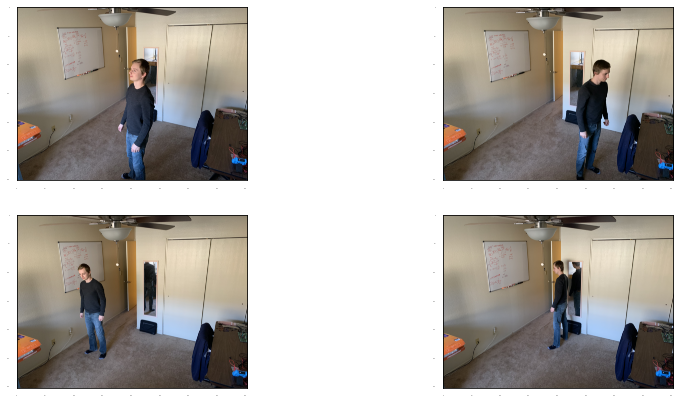

In [6]:
# Load images and visualize
path = os.path.join(os.getcwd(), "tensorflow_testing/models/research")
train_image_dir = "object_detection/test_images/person/test/"
train_images_np = []
for index in range(1, 5):
  image_path = os.path.join(path, train_image_dir + "t" + str(index) + ".jpg")
  train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for index, train_image_np in enumerate(train_images_np):
  plt.subplot(2, 2, index + 1)
  plt.imshow(train_image_np)
plt.show()

# Load Pre-Trained Model

Loading the Pre-Trained model with no modifications is actually extremely simple with the tf.saved_model functionality.

In [7]:
full_tf_model_dir = os.path.join( 
    path, "object_detection/ssd_mobilenet_v2/saved_model")
detection_model = tf.saved_model.load( full_tf_model_dir )

# Export and Run with TensorFlow Lite

## Model Conversion

In [9]:
%%bash
cd tensorflow_testing/models/research/
python object_detection/export_tflite_graph_tf2.py \
  --pipeline_config_path object_detection/ssd_mobilenet_v2/pipeline.config \
  --trained_checkpoint_dir object_detection/ssd_mobilenet_v2/checkpoint \
  --output_directory object_detection/tflite

2020-12-17 02:06:40.875243: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-12-17 02:06:40.875285: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2020-12-17 02:06:42.972757: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-17 02:06:42.981194: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-12-17 02:06:42.981233: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f27a2bc3a379): /proc/driver/nvidia/version does not exist
2020-12-17 02:06:42.981508: I tensorflow/c

In [12]:
%%bash
cd tensorflow_testing/models/research/
tflite_convert \
  --saved_model_dir=object_detection/tflite/saved_model \
  --output_file=object_detection/tflite/model.tflite

2020-12-17 02:09:51.507009: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-12-17 02:09:51.507159: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2020-12-17 02:09:53.650860: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-17 02:09:53.658845: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-12-17 02:09:53.658887: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f27a2bc3a379): /proc/driver/nvidia/version does not exist
2020-12-17 02:09:53.659157: I tensorflow/c

## Test .tflite Model

In [13]:
pipeline_config = os.path.join(
    path, "object_detection/ssd_mobilenet_v2/pipeline.config" )
configs = config_util.get_configs_from_pipeline_file( pipeline_config )
model_config = configs["model"]
#model_config.ssd.num_classes = 90 ## This line commented because we are not at this time making changes to the model.
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
    model_config=model_config, is_training=False)

In [17]:
test_image_dir = os.path.join(
    path, "object_detection/test_images/person/test/" )
test_images_np = []
for index in range(1, len( os.listdir( test_image_dir )) + 1 ):
  image_path = os.path.join(test_image_dir, 't' + str(index) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
def detect(interpreter, input_tensor):
  """Run detection on an input image.

  Args:
    interpreter: tf.lite.Interpreter
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # We use the original model for pre-processing, since the TFLite model doesn't
  # include pre-processing.
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  interpreter.set_tensor(input_details[0]['index'], preprocessed_image.numpy())

  interpreter.invoke()

  boxes = interpreter.get_tensor(output_details[0]['index'])
  classes = interpreter.get_tensor(output_details[1]['index'])
  scores = interpreter.get_tensor(output_details[2]['index'])
  return boxes, classes, scores


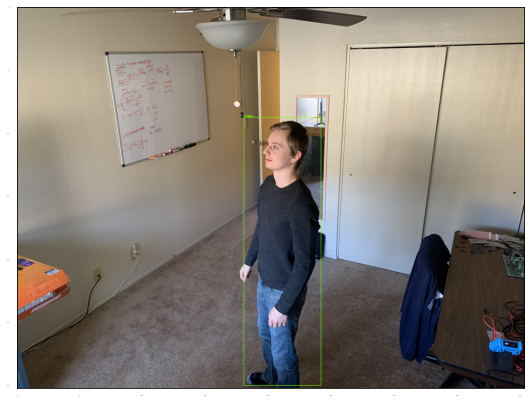

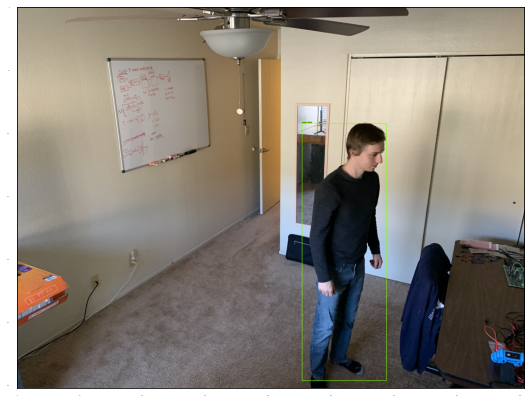

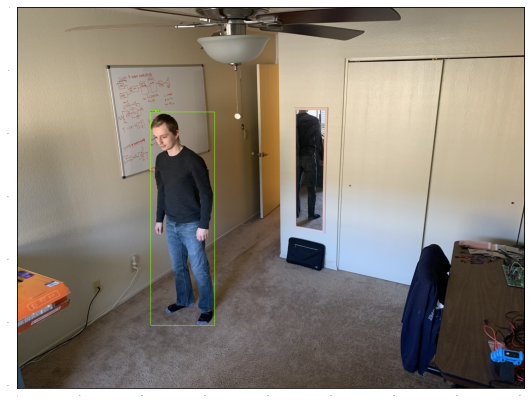

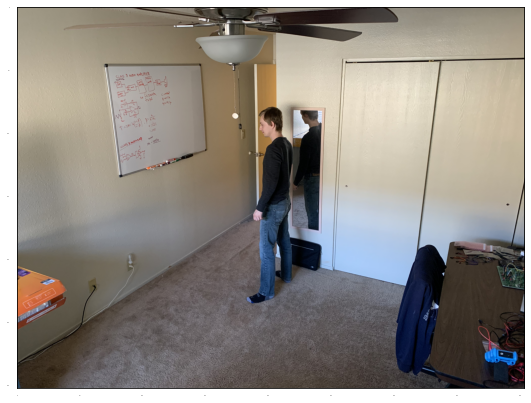

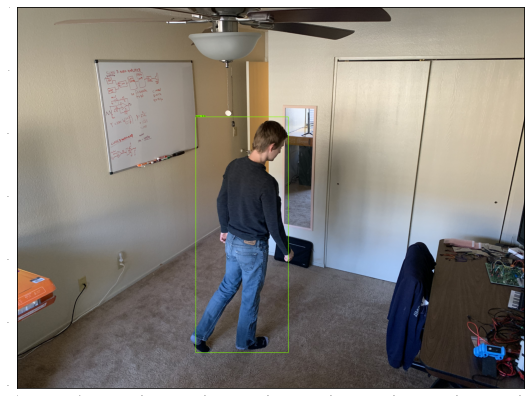

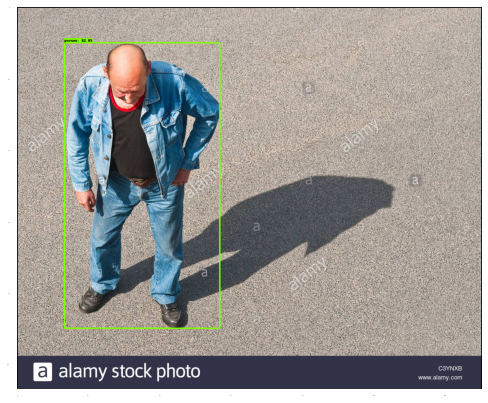

In [19]:
# Load the TFLite model and allocate tensors.
model_path = os.path.join(
    path, "object_detection/tflite/model.tflite" )
interpreter = tf.lite.Interpreter(
    model_path=model_path)
interpreter.allocate_tensors()

person_class_id = 1
category_index = { person_class_id: {"id": person_class_id, "name": "person" }}

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  boxes, classes, scores = detect(interpreter, input_tensor)

  plot_detections(
      test_images_np[i][0],
      boxes[0],
      classes[0].astype(np.uint32) + label_id_offset,
      scores[0],
      category_index, 
      figsize=(15, 20) )
  plt.show()

# Conclusion

We have now implemented a pre-trained TensorFlow object detection model into TensorFlow-Lite and successfully performed object detection!
To run on a local machine, you can use the python script equivalent to this file in **/models/research/object_detection/evaluate_tflite_model_tf2.ipynb**

**NOTE:** If the plots do not display automatically on a local machine due to a matplotlib *agg* warning, then simply check out the images in the **/test_images** folder.